# Projeto 1 - Ciência dos Dados

Nome: Pedro Henrique

Nome: Vitor Katakura

Atenção: Serão permitidos grupos de três pessoas, mas com uma rubrica mais exigente. Grupos deste tamanho precisarão fazer um questionário de avaliação de trabalho em equipe

___
Carregando algumas bibliotecas:

In [336]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

In [337]:
print('Esperamos trabalhar no diretório')
print(os.getcwd())

Esperamos trabalhar no diretório
/home/vitorhideki/www/python/cdados-p1


Carregando a base de dados com os tweets classificados manualmente e as stop words:

In [338]:
stop_words = pd.read_csv('stopwords.csv', header=None)[0].to_list()

In [339]:
train = pd.read_excel('dados_treino.xlsx')
train.head(5)

,Mensagem,Target,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,"Bem, eu nem sei por onde começar. A história é...",2,NaN,NaN,NaN
1,"Não gostei!, acabou com a expectativa que os o...",2,NaN,LEGENDA,NaN
2,"Venho por meio deste, expressar meu desapontam...",1,NaN,1,Problemas com a Amazon
3,"O começo do livro é bastante interessante, qun...",2,NaN,2,Comentarios sobre o livro
4,Veder essa porcaria como se fosse História é u...,2,NaN,3,Outros


In [340]:
test = pd.read_excel('dados_teste.xlsx')
test.head(5)

,Mensagem,Target,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,O livro fala de um contexto bastante interessa...,2,NaN,NaN,NaN
1,Estava muito empolgada com 90% do livro. As co...,2,NaN,LEGENDA,NaN
2,"História maluca e que não te leva a nada, uma ...",2,NaN,1,Problemas com a Amazon
3,"O autor tenta mostrar outro lado do livro, bus...",2,NaN,2,Comentarios sobre o livro
4,"Maçante, fantasioso. Uma ficção vista pelo ret...",2,NaN,3,Outros


In [341]:
stop_words = pd.read_csv('stopwords.csv', header=None)[0].to_list()

___
## Classificador automático


Na classificação dos tweets, nós consideramos que somos funcionários da Amazon e gostaríamos de filtrar quais comentários feitos por clientes são relacionados à problemas com a empresa. Para isso, utilizamos 3 variáveis relevantes na classificação: Problemas com a Amazon, comentários sobre o livro e outros.

* $A$: Problemas com a Amazon
* $L$: Comentários sobre o livro
* $O$: Outros


___
### Montando um Classificador Naive-Bayes

In [342]:
legenda = {'Problemas com a Amazon': 1, 'Comentários sobre o livro': 2, 'outros': 3}

In [343]:
# Removendo as colunas que não serão utilizadas
train = train.loc[:,['Mensagem', 'Target']]
test = test.loc[:,['Mensagem', 'Target']]

In [344]:
train.head()

,Mensagem,Target
0,"Bem, eu nem sei por onde começar. A história é...",2
1,"Não gostei!, acabou com a expectativa que os o...",2
2,"Venho por meio deste, expressar meu desapontam...",1
3,"O começo do livro é bastante interessante, qun...",2
4,Veder essa porcaria como se fosse História é u...,2


In [345]:
test.head()

,Mensagem,Target
0,O livro fala de um contexto bastante interessa...,2
1,Estava muito empolgada com 90% do livro. As co...,2
2,"História maluca e que não te leva a nada, uma ...",2
3,"O autor tenta mostrar outro lado do livro, bus...",2
4,"Maçante, fantasioso. Uma ficção vista pelo ret...",2


<b>Limpeza dos tweets</b>

Aqui implementamos uma função que recebe um texto e remove dele todas as pontuações, emoticons e stop words.

In [346]:
import re 

def cleanup(text):
    pattern = re.compile(r'[\`\"\!\-\.\:\?\;\$\'\,]')
    emoji_pattern = re.compile("["
                        u"\U0001F600-\U0001F64F"  # emoticons
                        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                        u"\U0001F680-\U0001F6FF"  # transport & map symbols
                        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                        u"\U00002702-\U000027B0"
                        u"\U000024C2-\U0001F251"
                        "]+", flags=re.UNICODE)
    
    texto_sem_pontos = re.sub(pattern, '', text)
    texto_sem_emoticons = re.sub(emoji_pattern, '', texto_sem_pontos)

    texto_limpo = ''
    for palavra in texto_sem_emoticons.split():
        if palavra not in stop_words:
            texto_limpo += palavra + ' '

    return texto_limpo.lower()

In [347]:
train['Mensagem'] = train['Mensagem'].apply(cleanup)
test['Mensagem'] = test['Mensagem'].apply(cleanup)
train_100 = train.copy()
test_100 = test.copy()

In [348]:
train.head()

,Mensagem,Target
0,bem sei onde começar a história representação ...,2
1,não gostei acabou expectativa outros livros de...,2
2,venho meio deste expressar desapontamento loja...,1
3,o começo livro bastante interessante qundo tud...,2
4,veder porcaria história crime afronta historia...,2


In [349]:
test.head()

,Mensagem,Target
0,o livro fala contexto bastante interessante po...,2
1,estava empolgada 90% livro as coisas começaram...,2
2,história maluca leva nada viagem sentido,2
3,o autor tenta mostrar outro lado livro buscand...,2
4,maçante fantasioso uma ficção vista retrovisor...,2


In [350]:
# Transformando os valores numéricos da variável target na base de dados treino em categóricos
train['Mensagem'] = train['Mensagem'].astype('category')
train['Target'] = train['Target'].astype('category')

train['Target'] = train['Target'].cat.rename_categories(['Problemas com a Amazon', 'Comentários sobre o livro', 'Outros'])

In [351]:
train.head()

,Mensagem,Target
0,bem sei onde começar a história representação ...,Comentários sobre o livro
1,não gostei acabou expectativa outros livros de...,Comentários sobre o livro
2,venho meio deste expressar desapontamento loja...,Problemas com a Amazon
3,o começo livro bastante interessante qundo tud...,Comentários sobre o livro
4,veder porcaria história crime afronta historia...,Comentários sobre o livro


In [352]:
# Transformando os valores numéricos da variável target na base de dados teste em categóricos
test['Mensagem'] = test['Mensagem'].astype('category')
test['Target'] = test['Target'].astype('category')

test['Target'] = test['Target'].cat.rename_categories(['Problemas com a Amazon', 'Comentários sobre o livro', 'Outros'])

In [353]:
test.head()

,Mensagem,Target
0,o livro fala contexto bastante interessante po...,Comentários sobre o livro
1,estava empolgada 90% livro as coisas começaram...,Comentários sobre o livro
2,história maluca leva nada viagem sentido,Comentários sobre o livro
3,o autor tenta mostrar outro lado livro buscand...,Comentários sobre o livro
4,maçante fantasioso uma ficção vista retrovisor...,Comentários sobre o livro


<b>Tabela de frequências das palavras</b>

Aqui, conseguimos obter as probabilidades de cada categoria:

* $P(A)$ = 0.686667
* $P(L)$ = 0.213333
* $P(O)$ = 0.1

In [354]:
tabela_relativa = train['Target'].value_counts(True)

P_amazon = tabela_relativa['Problemas com a Amazon']
P_livro = tabela_relativa['Comentários sobre o livro']
P_outros = tabela_relativa['Outros']
tabela_relativa.to_frame()

,proportion
Target,
Comentários sobre o livro,0.686667
Problemas com a Amazon,0.213333
Outros,0.100000


In [355]:
palavras = ''

for i in range(len(train['Mensagem'])):
    palavras += train['Mensagem'][i] + ' '

palavras = palavras.split()
palavras = pd.Series(list(set(palavras))) # Variável que armazena todas as palavras diferentes da base de treino
n_palavras_diff = len(palavras) # Variável que armazena a quantidade de palavras diferentes da base de treino

In [356]:
palavras_amazon = ''

amazon = train.loc[train['Target'] == 'Problemas com a Amazon', ['Mensagem']]
amazon = amazon.reset_index(drop=True)

for i in range(len(amazon['Mensagem'])):
    palavras_amazon += amazon['Mensagem'][i] + ' '

palavras_amazon_lista = palavras_amazon.split()
palavras_amazon = pd.Series(palavras_amazon_lista)
P_palavra_dado_amazon = palavras_amazon.value_counts() # Variável que armazena as palavras e suas respectivas quantidades de vezes que apareceram na categoria Amazon
n_palavras_amazon = len(palavras_amazon) # Variável que armazena a quantidade de palavras na categoria Amazon

In [357]:
palavras_livro = ''

livro = train.loc[train['Target'] == 'Comentários sobre o livro', ['Mensagem']]
livro = livro.reset_index(drop=True)

for i in range(len(livro['Mensagem'])):
    palavras_livro += livro['Mensagem'][i] + ' '

palavras_livro_lista = palavras_livro.split()
palavras_livro = pd.Series(palavras_livro_lista)
P_palavra_dado_livro = palavras_livro.value_counts() # Variável que armazena as palavras e suas respectivas quantidades de vezes que apareceram na categoria Livros
n_palavras_livro = len(palavras_livro) # Variável que armazena a quantidade de palavras na categoria Livros

In [358]:
palavras_outros = ''

outros = train.loc[train['Target'] == 'Outros', ['Mensagem']]
outros = outros.reset_index(drop=True)

for i in range(len(outros['Mensagem'])):
    palavras_outros += outros['Mensagem'][i] + ' '

palavras_outros_lista = palavras_outros.split()
palavras_outros = pd.Series(palavras_outros_lista)
P_palavra_dado_outros = palavras_outros.value_counts() # Variável que armazena as palavras e suas respectivas quantidades de vezes que apareceram na categoria Outros
n_palavras_outros = len(palavras_outros) # Variável que armazena a quantidade de palavras na categoria Outros

___
### Verificando a performance do Classificador

Aqui testaremos o nosso classificador utilizando os métodos de Naive Bayes e Suavização de Laplace

In [359]:
for i, frase in test['Mensagem'].items():
    frase = frase.split()
    prob_amazon = 1
    prob_livro = 1
    prob_outros = 1
    for palavra in frase:
        if palavra not in palavras_amazon_lista:
            prob_amazon *= (0 + 1)/(n_palavras_amazon + n_palavras_diff) * 10e2
        else:
            prob_amazon *= (P_palavra_dado_amazon[palavra] + 1)/(n_palavras_amazon + n_palavras_diff) * 10e2
        
        if palavra not in palavras_livro_lista:
            prob_livro *= (0 + 1)/(n_palavras_livro + n_palavras_diff) * 10e2
        else:
            prob_livro *= (P_palavra_dado_livro[palavra] + 1)/(n_palavras_livro + n_palavras_diff) * 10e2
        
        if palavra not in palavras_outros_lista:
            prob_outros *= (0 + 1)/(n_palavras_outros + n_palavras_diff) * 10e2
        else:
            prob_outros *= (P_palavra_dado_outros[palavra] + 1)/(n_palavras_outros + n_palavras_diff) * 10e2
    
    if prob_amazon > prob_livro and prob_amazon > prob_outros:
        test.loc[i, 'Predição'] = 'Problemas com a Amazon'
    elif prob_livro > prob_amazon and prob_livro > prob_outros:
        test.loc[i, 'Predição'] = 'Comentários sobre o livro'
    elif prob_outros > prob_amazon and prob_outros > prob_livro:
        test.loc[i, 'Predição'] = 'Outros'

In [360]:
test['Predição'] = test['Predição'].astype('category')

test['Predição'] = test['Predição'].cat.reorder_categories(['Problemas com a Amazon', 'Comentários sobre o livro', 'Outros'])

In [361]:
tabela = pd.crosstab(test['Predição'], test['Target'], normalize='all')
tabela

Target,Problemas com a Amazon,Comentários sobre o livro,Outros
Predição,,,
Problemas com a Amazon,0.190,0.030,0.055
Comentários sobre o livro,0.000,0.540,0.040
Outros,0.005,0.095,0.045


In [362]:
V_amazon = tabela['Problemas com a Amazon']['Problemas com a Amazon']
F_amazon = tabela['Comentários sobre o livro']['Problemas com a Amazon'] + tabela['Outros']['Problemas com a Amazon']
V_livro = tabela['Comentários sobre o livro']['Comentários sobre o livro']
F_livro = tabela['Problemas com a Amazon']['Comentários sobre o livro'] + tabela['Outros']['Comentários sobre o livro']
V_outros = tabela['Outros']['Outros']
F_outros = tabela['Comentários sobre o livro']['Outros'] + tabela['Problemas com a Amazon']['Outros']
Acur = V_amazon + V_livro + V_outros
print(V_amazon, F_amazon, V_livro, F_livro, V_outros, F_outros)

0.19 0.08499999999999999 0.54 0.04 0.045 0.1


___
## Concluindo

### Diferentes cenários para o classificador Naive-Bayes
* <b>Detector de plágio em texto de alunos</b> : A partir de uma base de dados com textos gerados por inteligências artificiais, é possível comparar as identidades textuais a fim de identificar algum plágio.

* <b>Detecção de Tópicos de Interesse</b> : Em aplicações de recomendação, o Naive-Bayes pode ajudar a identificar tópicos de interesse do usuário, analisando os textos que o usuário lê ou interage com regularidade.

___
### Qualidade do Classificador a partir de novas separações dos tweets entre Treinamento e Teste

Caso for fazer esse item do Projeto

In [363]:
import sklearn.model_selection as skl

In [364]:
train_100

,Mensagem,Target
0,bem sei onde começar a história representação ...,2
1,não gostei acabou expectativa outros livros de...,2
2,venho meio deste expressar desapontamento loja...,1
3,o começo livro bastante interessante qundo tud...,2
4,veder porcaria história crime afronta historia...,2
...,...,...
295,achei livro deu ênfase sexo realmente romance ...,2
296,não recomendo honestamente recomendo o conteúd...,2
297,fazer pedido vi pocket comentários espero sinc...,1
298,a personagem principal parece sofrer espécie m...,2


In [365]:
test_100

,Mensagem,Target
0,o livro fala contexto bastante interessante po...,2
1,estava empolgada 90% livro as coisas começaram...,2
2,história maluca leva nada viagem sentido,2
3,o autor tenta mostrar outro lado livro buscand...,2
4,maçante fantasioso uma ficção vista retrovisor...,2
...,...,...
195,no início achei interessante garota virgem apa...,2
196,cheio teorias conspiração,2
197,por versão pocket espera qualidade inferior as...,3
198,o livro ficcção destópica visa criticar certas...,2


In [366]:
dados_100 = pd.concat([train_100, test_100])
dados_100 = dados_100.reset_index(drop=True)
dados_100

,Mensagem,Target
0,bem sei onde começar a história representação ...,2
1,não gostei acabou expectativa outros livros de...,2
2,venho meio deste expressar desapontamento loja...,1
3,o começo livro bastante interessante qundo tud...,2
4,veder porcaria história crime afronta historia...,2
...,...,...
495,no início achei interessante garota virgem apa...,2
496,cheio teorias conspiração,2
497,por versão pocket espera qualidade inferior as...,3
498,o livro ficcção destópica visa criticar certas...,2


In [367]:
Acur_lista = []

In [368]:
for rs in range(100):
    train, test = skl.train_test_split(dados_100, test_size=0.4, random_state=rs)
    
    train = train.reset_index(drop=True)
    
    test = test.reset_index(drop=True)
    
    train['Mensagem'] = train['Mensagem'].astype('category')
    train['Target'] = train['Target'].astype('category')

    test['Mensagem'] = test['Mensagem'].astype('category')
    test['Target'] = test['Target'].astype('category')
    
    tabela_relativa = train.Target.value_counts(True)

    P_amazon = tabela_relativa[1]
    P_livro = tabela_relativa[2]
    P_outros = tabela_relativa[3]
    tabela_relativa

    palavras = ''

    for i in range(len(train['Mensagem'])):
        palavras += train['Mensagem'][i] + ' '

    palavras = palavras.split()
    palavras = pd.Series(list(set(palavras)))
    n_palavras_diff = len(palavras)

    palavras_amazon = ''

    amazon = train.loc[train['Target'] == 1, ['Mensagem']]
    amazon = amazon.reset_index(drop=True)

    for i in range(len(amazon['Mensagem'])):
        palavras_amazon += amazon['Mensagem'][i] + ' '

    palavras_amazon_lista = palavras_amazon.split()
    palavras_amazon = pd.Series(palavras_amazon_lista)
    P_palavra_dado_amazon = palavras_amazon.value_counts()
    n_palavras_amazon = len(palavras_amazon)

    palavras_livro = ''

    livro = train.loc[train['Target'] == 2, ['Mensagem']]
    livro = livro.reset_index(drop=True)

    for i in range(len(livro['Mensagem'])):
        palavras_livro += livro['Mensagem'][i] + ' '

    palavras_livro_lista = palavras_livro.split()
    palavras_livro = pd.Series(palavras_livro_lista)
    P_palavra_dado_livro = palavras_livro.value_counts()
    n_palavras_livro = len(palavras_livro)

    palavras_outros = ''

    outros = train.loc[train['Target'] == 3, ['Mensagem']]
    outros = outros.reset_index(drop=True)

    for i in range(len(outros['Mensagem'])):
        palavras_outros += outros['Mensagem'][i] + ' '

    palavras_outros_lista = palavras_outros.split()
    palavras_outros = pd.Series(palavras_outros_lista)
    P_palavra_dado_outros = palavras_outros.value_counts()
    n_palavras_outros = len(palavras_outros)

    for i, frase in test['Mensagem'].items():
        frase = frase.split()
        prob_amazon = 1
        prob_livro = 1
        prob_outros = 1
        for palavra in frase:
            if palavra not in palavras_amazon_lista:
                prob_amazon *= (0 + 1)/(n_palavras_amazon + n_palavras_diff) * 10e2
            else:
                prob_amazon *= (P_palavra_dado_amazon[palavra] + 1)/(n_palavras_amazon + n_palavras_diff) * 10e2
            
            if palavra not in palavras_livro_lista:
                prob_livro *= (0 + 1)/(n_palavras_livro + n_palavras_diff) * 10e2
            else:
                prob_livro *= (P_palavra_dado_livro[palavra] + 1)/(n_palavras_livro + n_palavras_diff) * 10e2
            
            if palavra not in palavras_outros_lista:
                prob_outros *= (0 + 1)/(n_palavras_outros + n_palavras_diff) * 10e2
            else:
                prob_outros *= (P_palavra_dado_outros[palavra] + 1)/(n_palavras_outros + n_palavras_diff) * 10e2
        
        if prob_amazon > prob_livro and prob_amazon > prob_outros:
            test.loc[i, 'Predição'] = 1
        elif prob_livro > prob_amazon and prob_livro > prob_outros:
            test.loc[i, 'Predição'] = 2
        elif prob_outros > prob_amazon and prob_outros > prob_livro:
            test.loc[i, 'Predição'] = 3

    test['Predição'] = test['Predição'].astype('category')
    test['Predição'] = test['Predição'].cat.reorder_categories([1, 2, 3])

    tabela = pd.crosstab(test['Predição'], test['Target'], normalize='all')
    V_amazon = tabela[1][1]
    V_livro = tabela[2][2]
    V_outros = tabela[3][3]
    Acur = V_amazon + V_livro + V_outros
    Acur_lista.append(Acur)

In [380]:
pd.DataFrame(Acur_lista).describe()

,0
count,100.000000
mean,0.767050
std,0.026978
min,0.690000
25%,0.750000
50%,0.765000
75%,0.785000
max,0.825000


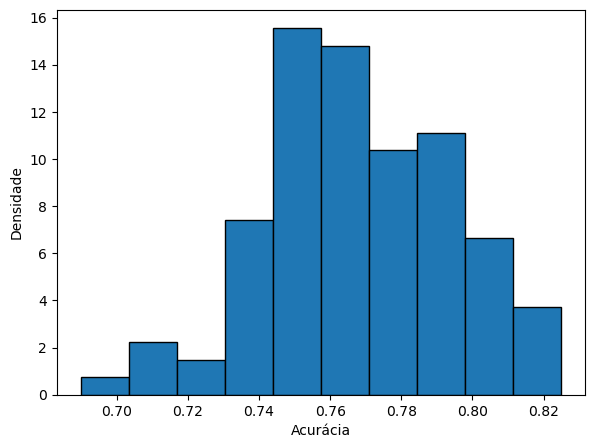

In [387]:
plt.figure(figsize=(15, 5))
plt.subplot(121)
plt.hist(Acur_lista, bins=10, density=True, edgecolor="black")
plt.xlabel("Acurácia")
plt.ylabel("Densidade")
plt.show()

___
## Aperfeiçoamento:

Trabalhos que conseguirem pelo menos conceito B vão evoluir em conceito dependendo da quantidade de itens avançados:

[X] IMPLEMENTOU outras limpezas e transformações que não afetem a qualidade da informação contida nos tweets. Ex: stemming, lemmatization, stopwords

[] CONSIDEROU mais de duas categorias na variável Target e INCREMENTOU a quantidade de notícias, mantendo pelo menos 250 notícias por categoria (OBRIGATÓRIO PARA TRIOS, sem contar como item avançado)

[X] Para Target com duas categorias: CRIOU pelo menos quatro categorias intermediárias de relevância baseadas na probabilidade: ex.: muito relevante, relevante, neutro, irrelevante, muito irrelevante

[] EXPLICOU porquê não pode usar o próprio classificador para gerar mais amostras de treinamento

[X] PROPÔS diferentes cenários para Naïve Bayes fora do contexto do projeto (pelo menos dois cenários, exceto aqueles já apresentados em sala pelos professores: por exemplo, filtro de spam)

[] SUGERIU e EXPLICOU melhorias reais com indicações concretas de como implementar (indicar como fazer e indicar material de pesquisa)

[X] FEZ o item Qualidade do Classificador a partir de novas separações das Notícias entre Treinamento e Teste descrito no enunciado do projeto (OBRIGATÓRIO para conceitos A ou A+)

___
## Referências

[Naive Bayes and Text Classification](https://arxiv.org/pdf/1410.5329.pdf)  **Mais completo**

[A practical explanation of a Naive Bayes Classifier](https://monkeylearn.com/blog/practical-explanation-naive-bayes-classifier/) **Mais simples**